In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import average_precision_score, precision_recall_fscore_support, accuracy_score, roc_curve, roc_auc_score
import numpy as np
import keras
import matplotlib.pyplot as plt

In [2]:
SEQ_SIZE = 151

fontsize = 24
train_file_path = "train_data.csv"

df = pd.read_csv(train_file_path)
df = df.sample(frac = 1)

split_data = int(df.shape[0]*0.8)
train_data = df[:split_data]
test_data = df[split_data:]
train_labels = train_data.pop(train_data.columns[0])
train_labels_cat = to_categorical(train_labels, num_classes=2)
train_data = to_categorical(train_data.values.reshape(train_data.shape[0], SEQ_SIZE, 1), num_classes=4)
test_labels = test_data.pop(test_data.columns[0])
test_labels_cat = to_categorical(test_labels, num_classes=2)
test_data = to_categorical(test_data.values.reshape(test_data.shape[0], SEQ_SIZE, 1), num_classes=4)

In [3]:
def get_identity_block(inpt, num_filts, filt_sz = 3, activation = tf.nn.relu6, strides = 1, pad = 'same', ):
    conv_layer = tf.keras.layers.Conv1D(
        filters = num_filts, kernel_size = filt_sz, 
        strides = strides, kernel_regularizer='L1L2', 
        padding = pad, data_format='channels_last', use_bias=False)(inpt)
    batch_norm = tf.keras.layers.BatchNormalization(scale = False,)(conv_layer)
    act_layer = tf.keras.layers.Activation(activation)(batch_norm)
    conv_layer = tf.keras.layers.Conv1D(
        filters = num_filts, kernel_size = filt_sz, 
        strides = strides, kernel_regularizer='L1L2', 
        padding = pad, data_format='channels_last', use_bias=False)(act_layer)
    batch_norm = tf.keras.layers.BatchNormalization(scale = False,)(conv_layer)
    act_layer = tf.keras.layers.Activation(activation)(batch_norm)
    add_layer = tf.keras.layers.add([inpt, act_layer])
    return tf.keras.layers.Activation(activation)(add_layer)

def get_resblock(inpt, num_filts, filt_sz = 3, activation = tf.nn.relu6, strides = 1, pad = 'same', ):
    conv_layer = tf.keras.layers.Conv1D(
        filters = num_filts, kernel_size = filt_sz, 
        strides = strides, kernel_regularizer='L1L2', 
        padding = pad, data_format='channels_last', use_bias=False)(inpt)
    batch_norm = tf.keras.layers.BatchNormalization(scale = False,)(conv_layer)
    act_layer = tf.keras.layers.Activation(activation)(batch_norm)
    conv_layer = tf.keras.layers.Conv1D(
        filters = num_filts, kernel_size = filt_sz, 
        strides = strides, kernel_regularizer='L1L2', 
        padding = pad, data_format='channels_last', use_bias=False)(act_layer)
    batch_norm = tf.keras.layers.BatchNormalization(scale = False,)(conv_layer)
    act_layer = tf.keras.layers.Activation(activation)(batch_norm)
    conv_1_1 = tf.keras.layers.Conv1D(
        filters = num_filts, kernel_size = 1, 
        strides = 1, kernel_regularizer='L1L2', 
        padding = pad, data_format='channels_last', use_bias=False)(inpt)
    add_layer = tf.keras.layers.add([conv_1_1, act_layer])
    return tf.keras.layers.Activation(activation)(add_layer)

def get_compiled_model():

    relu_act = tf.keras.layers.Activation(tf.nn.relu6)

    input_layer = tf.keras.layers.Input(batch_shape=(None, SEQ_SIZE, 4), name='input')
    pad_layer = tf.keras.layers.ZeroPadding1D(3)(input_layer)
    x = tf.keras.layers.Conv1D(64, kernel_size=7, strides=2, padding='same')(pad_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(x)

    
    block_layers = [3, 4, 6, 3]
    filter_size = 64

    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = get_identity_block(x, filter_size)
        else:
            filter_size = filter_size*2
            x = get_resblock(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = get_identity_block(x, filter_size)

    x = tf.keras.layers.AveragePooling1D(2, padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(2, activation = 'softmax')(x)

    model = tf.keras.models.Model(inputs = input_layer, outputs = x, name = "ResNet34")
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss = tf.losses.categorical_crossentropy, metrics=['accuracy'])
    model.summary()
    return model

model = get_compiled_model()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 151, 4)]     0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 157, 4)      0           ['input[0][0]']                  
                                                                                                  
 conv1d (Conv1D)                (None, 79, 64)       1856        ['zero_padding1d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 79, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                

 rmalization)                                                                                     
                                                                                                  
 conv1d_9 (Conv1D)              (None, 40, 128)      8192        ['activation_10[0][0]']          
                                                                                                  
 activation_12 (Activation)     (None, 40, 128)      0           ['batch_normalization_8[0][0]']  
                                                                                                  
 add_3 (Add)                    (None, 40, 128)      0           ['conv1d_9[0][0]',               
                                                                  'activation_12[0][0]']          
                                                                                                  
 activation_13 (Activation)     (None, 40, 128)      0           ['add_3[0][0]']                  
          

                                                                                                  
 add_7 (Add)                    (None, 40, 256)      0           ['conv1d_18[0][0]',              
                                                                  'activation_24[0][0]']          
                                                                                                  
 activation_25 (Activation)     (None, 40, 256)      0           ['add_7[0][0]']                  
                                                                                                  
 conv1d_19 (Conv1D)             (None, 40, 256)      196608      ['activation_25[0][0]']          
                                                                                                  
 batch_normalization_17 (BatchN  (None, 40, 256)     768         ['conv1d_19[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 batch_normalization_25 (BatchN  (None, 40, 256)     768         ['conv1d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_38 (Activation)     (None, 40, 256)      0           ['batch_normalization_25[0][0]'] 
                                                                                                  
 conv1d_28 (Conv1D)             (None, 40, 256)      196608      ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_26 (BatchN  (None, 40, 256)     768         ['conv1d_28[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 dense_1 (Dense)                (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
Total params: 12,469,954
Trainable params: 12,454,722
Non-trainable params: 15,232
__________________________________________________________________________________________________


In [4]:
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience = 4, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [early, redonplat, tf.keras.callbacks.TensorBoard('logs')]

In [5]:
hist = model.fit(train_data, train_labels_cat, epochs=100, validation_split=0.20, batch_size=32, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
1184/1184 [==============================] - 103s 75ms/step - loss: 0.7903 - accuracy: 0.6814 - val_loss: 0.4969 - val_accuracy: 0.7565 - lr: 0.0010
Epoch 2/100
1184/1184 [==============================] - 88s 74ms/step - loss: 0.4660 - accuracy: 0.7843 - val_loss: 0.5718 - val_accuracy: 0.7394 - lr: 0.0010
Epoch 3/100
1184/1184 [==============================] - 82s 69ms/step - loss: 0.4339 - accuracy: 0.8063 - val_loss: 0.4664 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 4/100
1184/1184 [==============================] - 83s 71ms/step - loss: 0.4135 - accuracy: 0.8177 - val_loss: 0.4584 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 5/100
1184/1184 [==============================] - 81s 69ms/step - loss: 0.3966 - accuracy: 0.8269 - val_loss: 0.5040 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 6/100
1184/1184 [==============================] - 80s 68ms/step - loss: 0.3800 - accuracy: 0.8379 - val_loss: 0.4455 - val_accuracy: 0.7980 - lr: 0.0010
Epoch 7/100
1184/1184 [================

In [6]:
pred_test = np.argmax(model.predict(test_data), axis = 1)
accuracy = accuracy_score(test_labels, pred_test)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.8331784779119858


In [7]:
cf_m = tf.math.confusion_matrix(test_labels, pred_test, num_classes=2)
print(cf_m)

tf.Tensor(
[[4928  946]
 [1029 4936]], shape=(2, 2), dtype=int32)


In [8]:
recall = precision_recall_fscore_support(test_labels, pred_test, average="binary")
print('Precision: {0:0.2f}'.format(recall[0]))
print('Recall: {0:1.2f}'.format(recall[1]))
print('F1-Score: {0:2.2f}'.format(recall[2]))

Precision: 0.84
Recall: 0.83
F1-Score: 0.83


In [9]:
pred_test = np.argmax(model.predict(test_data), axis = 1)
pred_test = to_categorical(pred_test)
ns_auc = roc_auc_score(test_labels_cat[:, 0], pred_test[:, 0])
lr_auc = roc_auc_score(test_labels_cat[:, 1], pred_test[:, 1])
print('Non-Promoter: ROC AUC=%.3f' % (ns_auc))
print('Promoter: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(test_labels_cat[:, 0], pred_test[:, 0])
lr_fpr, lr_tpr, _ = roc_curve(test_labels_cat[:, 1], pred_test[:, 1])

Non-Promoter: ROC AUC=0.833
Promoter: ROC AUC=0.833


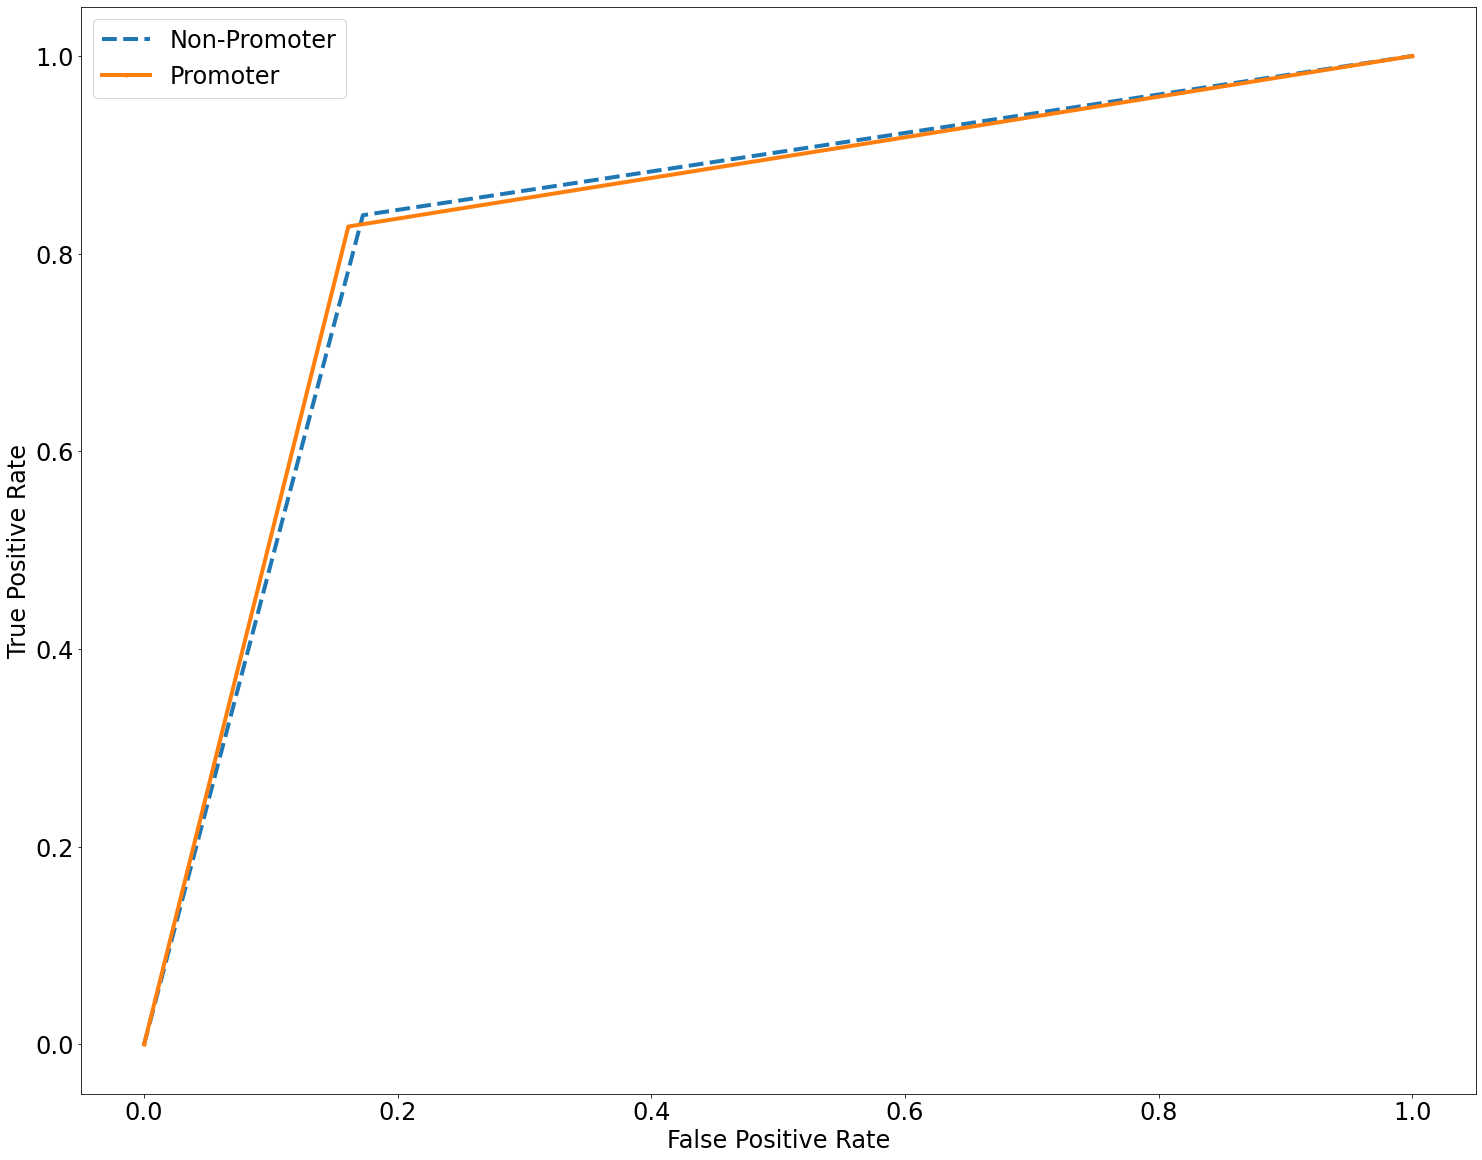

In [10]:
fig = plt.figure(figsize=(25, 20))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Non-Promoter', linewidth=4)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Promoter', linewidth=4)
plt.xlabel('False Positive Rate', fontsize=fontsize)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.savefig("roc_resnet.png")

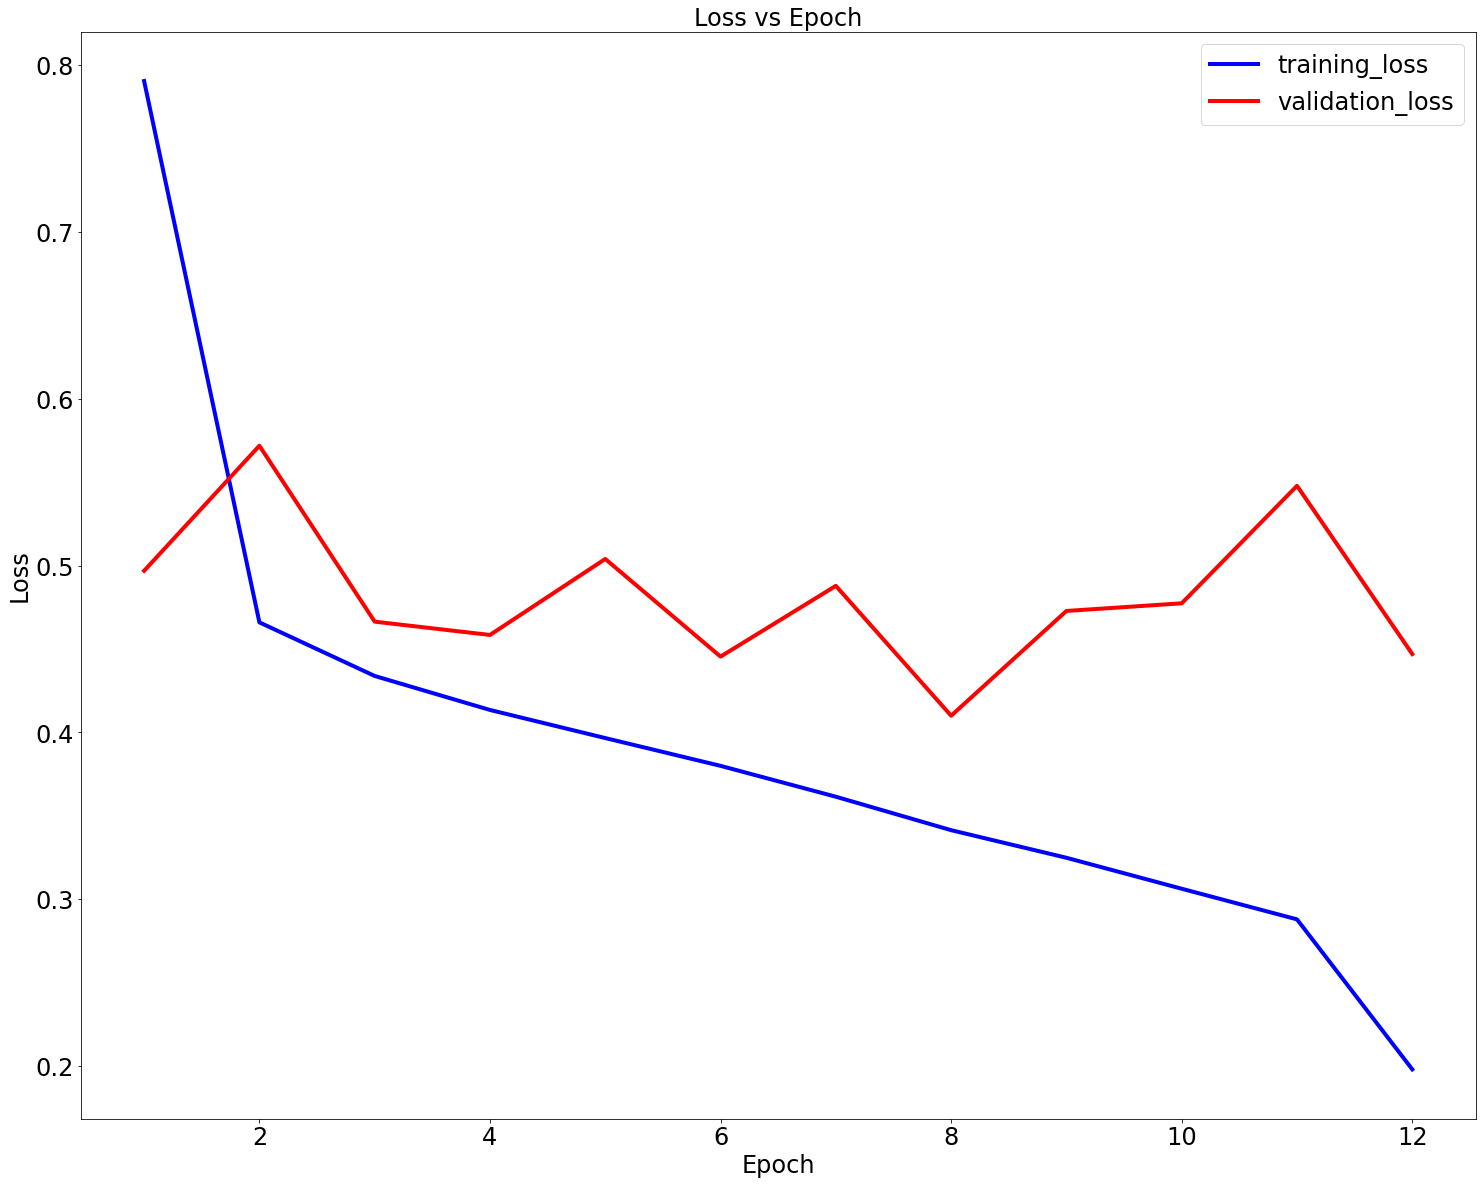

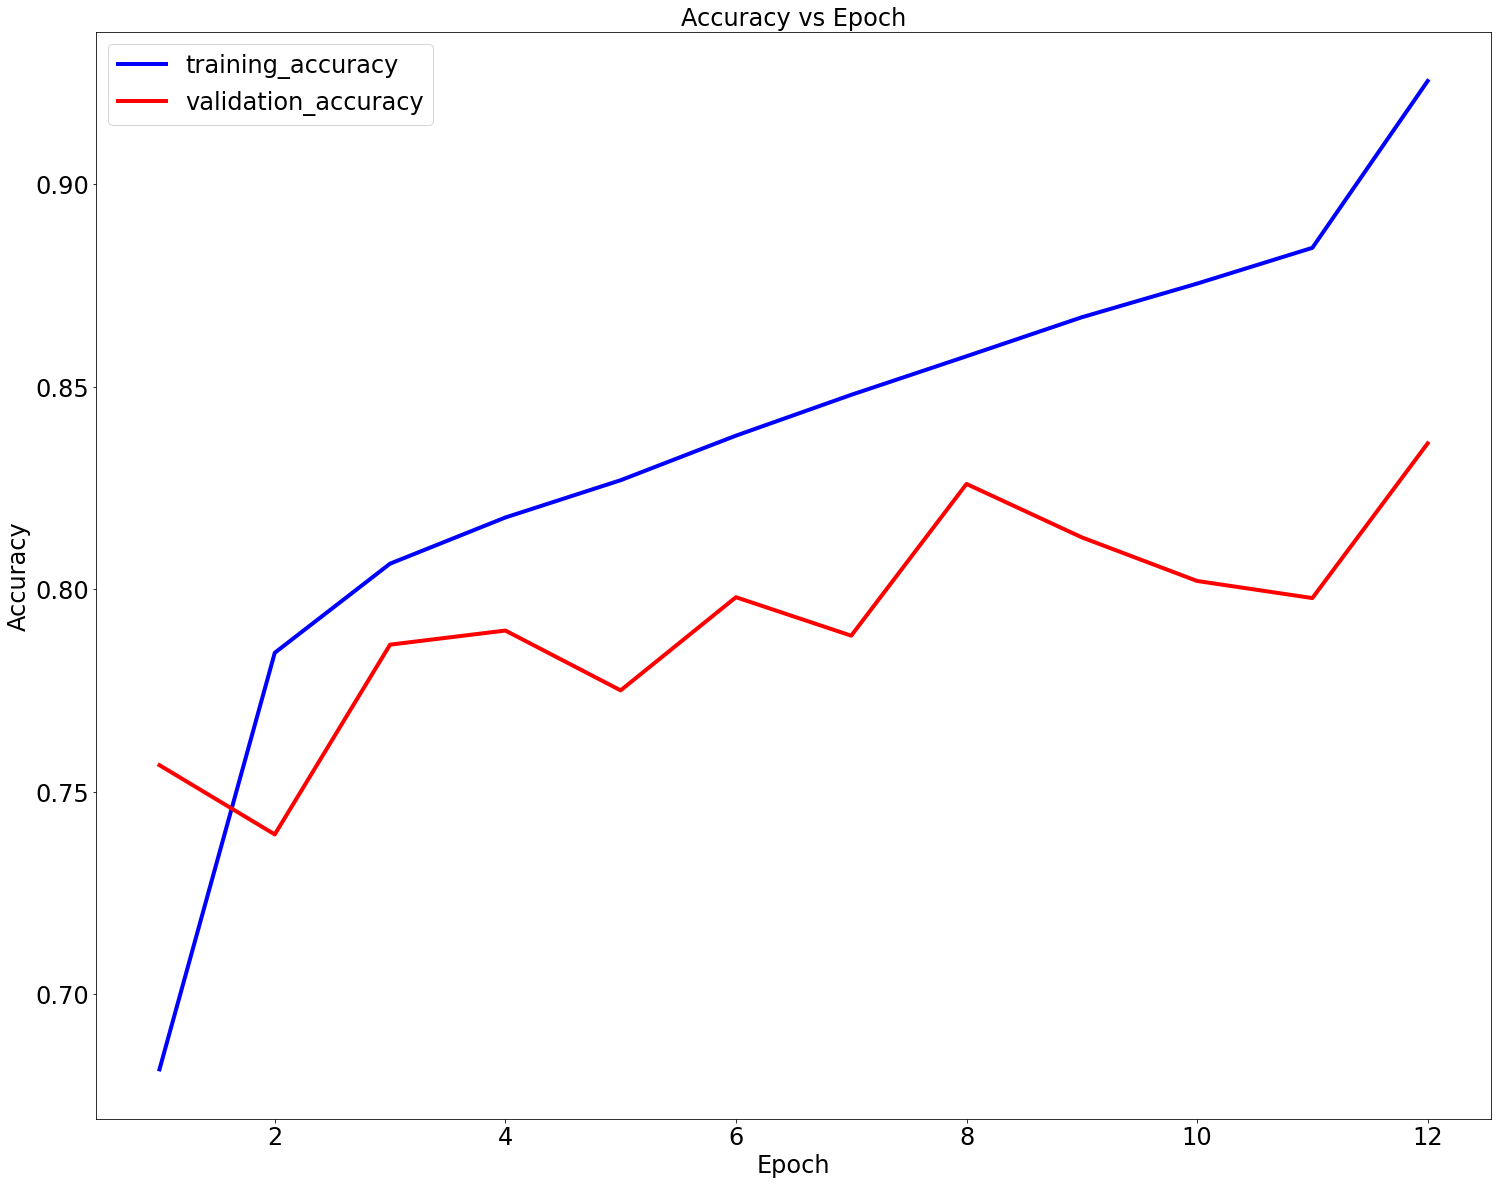

In [11]:
summ = hist.history

epochs = [i for i in range(1, len(summ['loss'])+1)]

fig = plt.figure(figsize=(25, 20))
plt.plot(epochs, summ['loss'], color='blue', label="training_loss", linewidth=4)
plt.plot(epochs, summ['val_loss'], color='red', label="validation_loss", linewidth=4)
plt.legend(loc='best', fontsize=fontsize)
plt.title('Loss vs Epoch', fontsize=fontsize)
plt.ylabel('Loss', fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.show()
plt.savefig("loss_resnet.png")

fig = plt.figure(figsize=(25, 20))
plt.plot(epochs, summ['accuracy'], color='blue', label="training_accuracy", linewidth=4)
plt.plot(epochs, summ['val_accuracy'], color='red',label="validation_accuracy", linewidth=4)
plt.legend(loc='best', fontsize=fontsize)
plt.title('Accuracy vs Epoch', fontsize=fontsize)
plt.ylabel('Accuracy', fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
# plt.show()
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig("accuracy_resnet.png")